# Turb2D Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

Load the dataset class

In [15]:
from kolmopy.datasets.turb2D import Turb2D

data_path = Path('..','.cached','Turb2D.hdf5')
data_path.exists()

# initialize the dataset (this does not load the data)
turb2D = Turb2D(data_path)
print(turb2D)

Turb2D stored in ../.cached/Turb2D.hdf5.
- variables dict_keys(['xy', 't'])
- fields: dict_keys(['uv', 'particle', 'scalar']) 


In [4]:
turb2D.cite()

========== BibTeX ==========

@misc{heitz2007deliverable,
  title={Final report on the evaluation of the tasks of the workpackage 2, FLUID project deliverable 5.4.},
  author={Heitz, Dominique and Carlier, Johan and Arroyo, Georges and Szantai, Andr{'e}}
  year={2007},
}



In [5]:
turb2D.validate()

Check data dimensions... done!


## Single Image processing

In [16]:
time_idx = 666
turb2D.load_data(time_idx, only_vel_field=False)

xy = turb2D.xy
uv = turb2D.uv

print(xy.shape)
print(uv.shape)

(256, 256, 2)
(256, 256, 2)


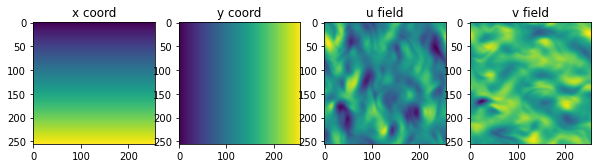

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(141)
plt.title('x coord')
plt.imshow(xy[:,:,0])
plt.subplot(142)
plt.title('y coord')
plt.imshow(xy[:,:,1])
plt.subplot(143)
plt.title('u field')
plt.imshow(uv[:,:,0])
plt.subplot(144)
plt.title('v field')
plt.imshow(uv[:,:,1])
plt.show()

note that the coordinate system $(x,y)$ is implement with `ij` indexing system. 

This should be always specified in order to compute the gradient in the correct direction.

### Some visualization tools and physics tools

In [8]:
import kolmopy.utils.viz_utils as viz
import kolmopy.utils.phy_utils as phy

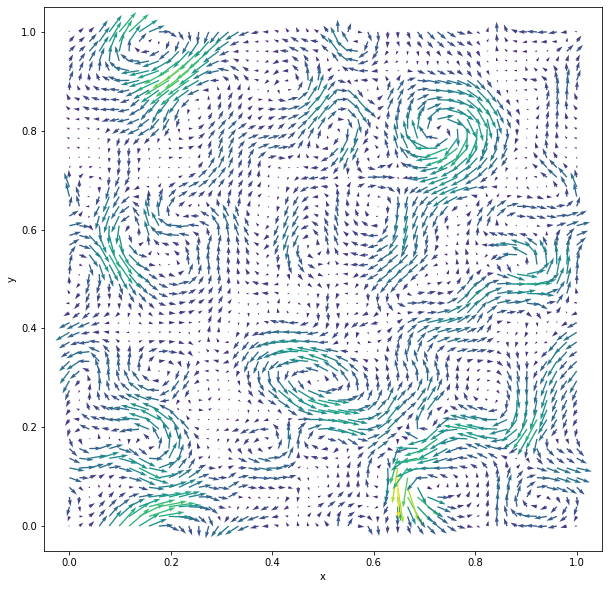

In [9]:
# plot the 2D velocity field (u,v) defined over the coordinates (x,y)
# note that

fig, ax = plt.subplots(figsize=(10,10))
viz.plot_2D_velocity_field(xy, uv, step=5, scale=50, ax=ax)
plt.show()

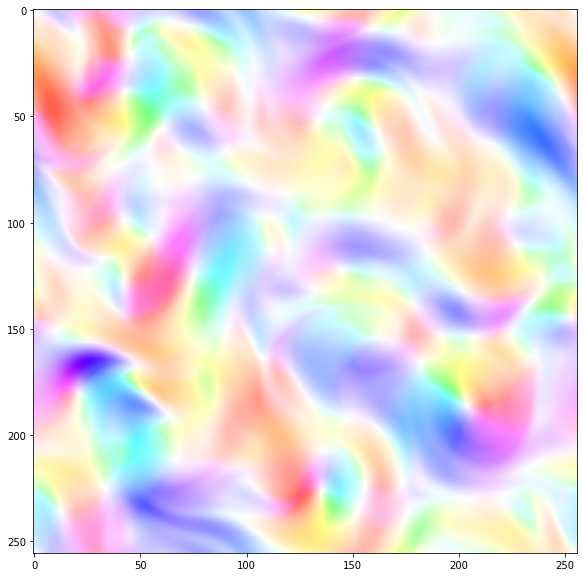

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
viz.plot_middlebury_colors(uv, ax=ax)
plt.show()

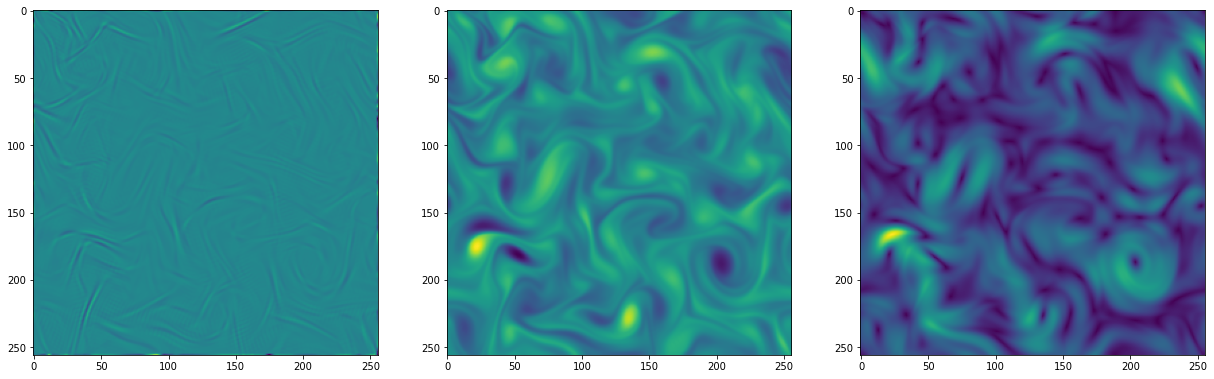

In [11]:
fig, ax = plt.subplots(figsize=(21,7))

d = phy.compute_divergence(xy, uv, order=1)
w = phy.compute_vorticity(xy, uv, order=1)
m = phy.compute_magnitude(uv)

plt.subplot(131)
plt.imshow(d)
plt.subplot(132)
plt.imshow(w)
plt.subplot(133)
plt.imshow(m)
plt.show()

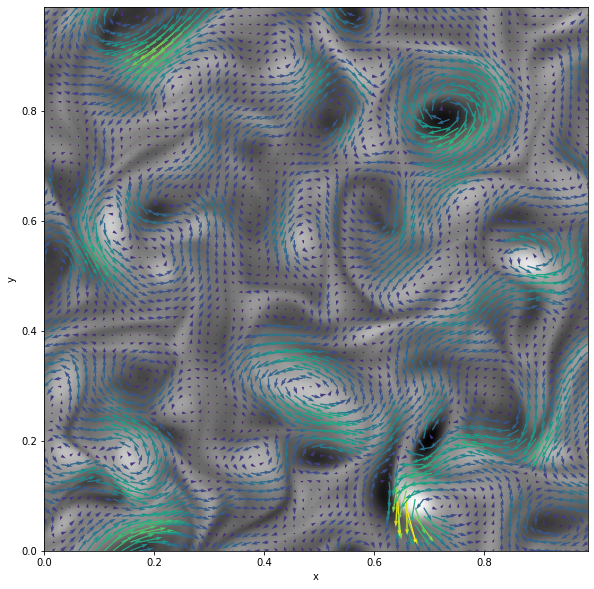

In [12]:
# attention to the direction of the axis in the vorticity image
# the quiver is plotted for xy indexing system, while we computed the vorticiy in the ij 

fig, ax = plt.subplots(figsize=(10,10))
viz.plot_2D_velocity_field(xy, uv, step=4, scale=50, ax=ax,
        bg_img=w, bg_img_indexing='ij')
plt.show()

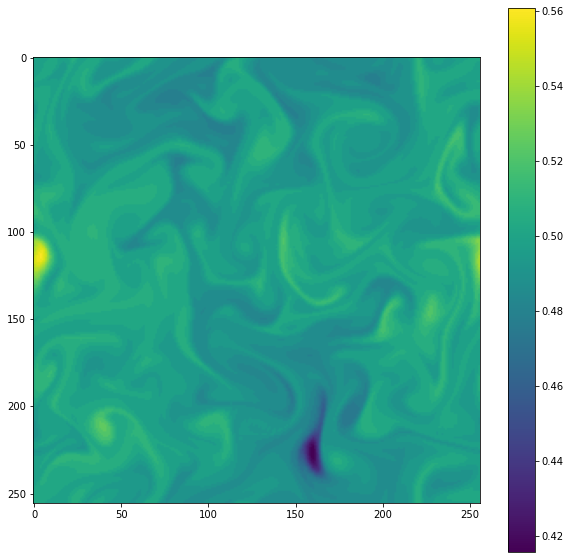

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(turb2D.scalar)
plt.colorbar()
plt.show()

s = turb2D.scalar

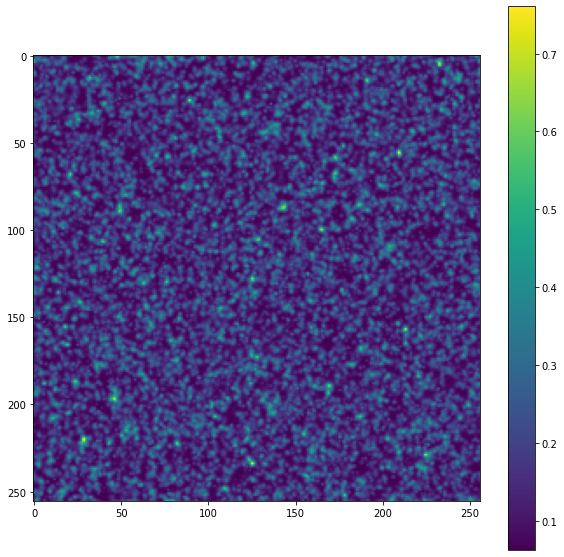

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(turb2D.particle)
plt.colorbar()
plt.show()

## Physics utilities

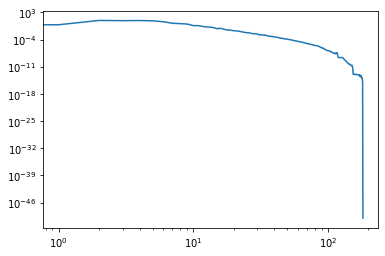

In [19]:
spec, freqs = phy.powerspec(uv)

plt.loglog(freqs, spec)

# Multiple images

In [20]:
from tqdm import tqdm
from IPython.display import HTML
from matplotlib import animation

In [21]:
t = np.arange(200)
turb2D.load_data(t, only_vel_field=True)

In [99]:
ani = viz.animate_image(turb2D.uv[:,:,:,0])
HTML(ani.to_html5_video())

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1057.71it/s]


In [102]:
xy_t = turb2D.xy
uv_t = turb2D.uv

ani = viz.animate_2D_velocity_field(xy_t, uv_t, show_vorticity=True, step=5, scale=50)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 705.91it/s]


In [103]:
HTML(ani.to_html5_video())

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '360x360', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp7xmkjeg8/temp.m4v']' returned non-zero exit status 255.

Plot Energy Spectrum of sequences

In [ ]:
def energy_spectrum(vel):
    """
    Compute energy spectrum given a velocity field
    :param vel: tensor of shape (N, 3, res, res, res)
    :return spec: tensor of shape(N, res/2)
    :return k: tensor of shape (res/2,), frequencies corresponding to spec
    """
    device = vel.device
    res = vel.shape[-2:]

    assert(res[0] == res[1])
    r = res[0]
    k_end = int(r/2)
    vel_ = pad_rfft3(vel, onesided=False) # (N, 3, res, res, res, 2)
    uu_ = (torch.norm(vel_, dim=-1) / r**3)**2
    e_ = torch.sum(uu_, dim=1)  # (N, res, res, res)
    k = fftfreqs(res).to(device) # (3, res, res, res)
    rad = torch.norm(k, dim=0) # (res, res, res)
    k_bin = torch.arange(k_end, device=device).float()+1
    bins = torch.zeros(k_end+1).to(device)
    bins[1:-1] = (k_bin[1:]+k_bin[:-1])/2
    bins[-1] = k_bin[-1]
    bins = bins.unsqueeze(0)
    bins[1:] += 1e-3
    inds = torch.searchsorted(bins, rad.flatten().unsqueeze(0)).squeeze().int()
    # bincount = torch.histc(inds.cpu(), bins=bins.shape[1]+1).to(device)
    bincount = torch.bincount(inds)
    asort = torch.argsort(inds.squeeze())
    sorted_e_ = e_.view(e_.shape[0], -1)[:, asort]
    csum_e_ = torch.cumsum(sorted_e_, dim=1)
    binloc = torch.cumsum(bincount, dim=0).long()-1
    spec_ = csum_e_[:,binloc[1:]] - csum_e_[:,binloc[:-1]]
    spec_ = spec_[:, :-1]
    spec_ = spec_ * 2 * np.pi * (k_bin.float()**2) / bincount[1:-1].float()
    return spec_, k_bin

Validate Navier-Stokes equation

In [23]:
xy = turb2D.xy
uv = turb2D.uv
t = turb2D.t

print(xy_t.shape)
print(uv_t.shape)
print(t.shape)

(200, 256, 256, 2)
(200, 256, 256, 2)
(200,)


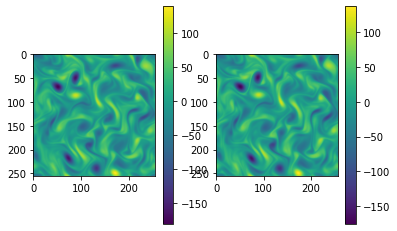

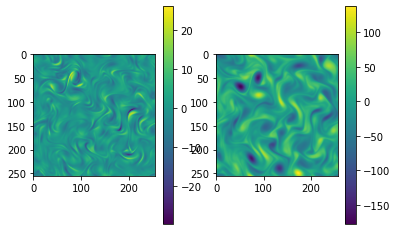

In [32]:
i = 50

uv_i = uv[i,...]
xy_i = xy[i,...]
uv_1 = uv[i-1,...]
xy_1 = xy[i-1,...]
uv_2 = uv[i+1,...]
xy_2 = xy[i+1,...]

dt = t[i+1] - t[i-1]

w_1 = phy.compute_vorticity(xy_1, uv_1)
w_2 = phy.compute_vorticity(xy_2, uv_2)
w_i = phy.compute_vorticity(xy_i, uv_i)

dw = (w_2 - w_1) / 2

plt.subplot(121)
plt.imshow(w_2)
plt.colorbar()
plt.subplot(122)
plt.imshow(w_1)
plt.colorbar()
plt.show()


plt.subplot(121)
plt.imshow(dw)
plt.colorbar()
plt.subplot(122)
plt.imshow(w_i)
plt.colorbar()

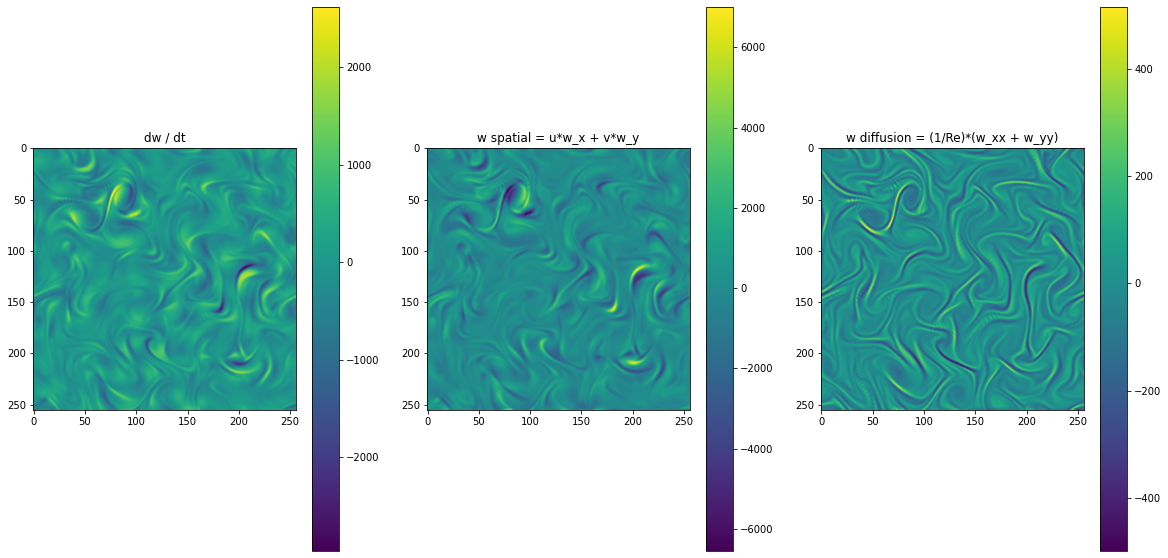

In [86]:
x = xy_1[:,0,0]
y = xy_1[0,:,1]

u = uv_1[:,:,0]
v = uv_1[:,:,1]

u_xy, v_xy = phy.my_grad([u, v], [x, y], indexing='ij', order=2)
u_x, u_y = u_xy
v_x, v_y = v_xy

w_x, w_y = w_xy = phy.my_grad([w], [x, y], indexing='ij', order=2)[0]

w_x_xy, w_y_xy = phy.my_grad([w_x, w_y], [x, y], indexing='ij', order=2)
w_xx, w_xy = w_x_xy
w_yx, w_yy = w_y_xy

w_spatial = u*w_x + v*w_y
w_diffusion = -(w_xx + w_yy)/3000.
dt = t[i]  - t[i-1]
w_t = 0.5*(w_2 - w_i)/dt + 0.5*(w_i - w_1)/dt

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('dw / dt')
plt.imshow(w_t)
plt.colorbar()
plt.subplot(132)
plt.title('w spatial = u*w_x + v*w_y')
plt.imshow(w_spatial)
plt.colorbar()
plt.subplot(133)
plt.title('w diffusion = (1/Re)*(w_xx + w_yy)')
plt.imshow(w_diffusion)
plt.colorbar()
plt.show()

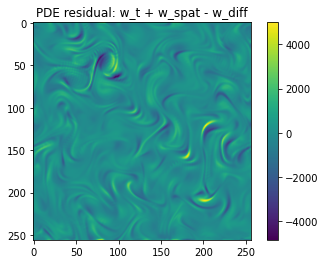

In [87]:
plt.title('PDE residual: w_t + w_spat - w_diff')
plt.imshow(w_t + w_spatial + w_diffusion)
plt.colorbar()